# Intro

We will be working with the data from [NHANES](https://wwwn.cdc.gov/nchs/nhanes/continuousnhanes/default.aspx?BeginYear=2017), which is the the National Health and Nutrition Examination Survey, conducted by the National Center for Health Statistics (USA). 

They follow up the survey participants for 2 years and also ask relevant demographic and dietary questions and also life-style related.

For each study (they are made every two years), we find data about:
- demographics
- diet
- examination
- laboratory
- questionnaire (mainly lifestyle related)

With this data we will try to predict a few diseases such as heart diseases or asthma.

As the data is quite noise, full of NaNs, etc... I took the surveys from several year-pairs:
- 2013-2014
- 2015-2016
- 2017-2018

This should be no problem, as it isn't a temporal serie. The survey methods can be consulted in the website.

In [1]:
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

from imblearn.over_sampling import SMOTE

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks

import os, sys

# Helpers
abspath = os.path.abspath
dirname = os.path.dirname
sep = os.sep
file_ = os.getcwd()

ml_folder = dirname(file_)
sys.path.append(ml_folder)

from src.utils import mining_data_tb as md
from src.utils import visualization_tb as vi
from src.utils import folder_tb as fo
from src.utils import models as mo


import warnings

warnings.filterwarnings("ignore")

# Data exploration

In [2]:
# As the data variables are coded (for instance, "RIAGENDR" is Gender), we first need to load the variable descriptions. For that, we will create an object with all the info and methods to change names whenever necessary

# 1) We create the object
vardata = md.variables_data()

# 2) We load the info
variables_data_path = fo.path_to_folder(2, "data" + sep + "health" + sep + "6_variables") + "0_final_variables.csv"
vardata.load_data(variables_data_path)

In [3]:
# Now we can load the actual dataset we will be using for the ml models

# 1) Create object
dataset = md.dataset()

# 2) Path and folders where the data is
data_path = fo.path_to_folder(2, "data" + sep + "health")
folders = ["1_demographics", "2_dietary", "3_examination", "4_laboratory", "5_questionnaire"]

# Some extra processing required
columns_correction = {
            "WTDRD1_x" : "WTDRD1",
            "WTDR2D_x" : "WTDR2D",
            "DRABF_x" : "DRABF",
            "DRDINT_x" : "DRDINT",
            "WTSAF2YR_x" : "WTSAF2YR",
            "LBXHCT_x" : "LBXHCT"
        }

# 3) Load data
dataset.load_data(data_path, folders, columns_correction)

In [4]:
### DON'T EXECUTE THIS ONE

# Before doing any cleaning or transformation, let's save this dataset
path_to_save = data_path + "7_cleaned_data" + sep + "raw_data.csv"
#dataset.df.to_csv(path_to_save)

In [5]:
# With this, we can do a first exploration. For that, we can access the df though the object attribute "df"

print(dataset.df.shape, "\n")
dataset.df.head(2)

(29213, 951) 



,SDDSRVYR,RIDSTATR,RIAGENDR,RIDAGEYR,RIDAGEMN,RIDRETH1,RIDRETH3,RIDEXMON,RIDEXAGM,DMQMILIZ,...,SMQ690F,SMQ830,SMQ840,SMDANY,SMAQUEX,SMQ690I,SMQ857,SMQ690J,SMQ861,MCQ160H
SEQN,,,,,,,,,,,,,,,,,,,,,
83732,9,2,1,62,NaN,3,3,1.0,NaN,2.0,...,NaN,NaN,NaN,2.0,2.0,NaN,NaN,NaN,NaN,0.0
83733,9,2,1,53,NaN,3,3,1.0,NaN,2.0,...,NaN,NaN,NaN,1.0,2.0,NaN,NaN,NaN,NaN,0.0


In [6]:
# This are our (target) variables
print("Asthma:\n", dataset.df.MCQ010.value_counts())
print("-" * 50)
print("Congestive heart failure:\n", dataset.df.MCQ160B.value_counts())
print("-" * 50)
print("Cononary heart disease:\n", dataset.df.MCQ160C.value_counts())
print("-" * 50)
print("Angina pectoris:\n", dataset.df.MCQ160D.value_counts())
print("-" * 50)
print("Heart attack:\n", dataset.df.MCQ160E.value_counts())
print("-" * 50)
print("Stroke:\n", dataset.df.MCQ160F.value_counts())
print("-" * 50)
print("Any cardiovascular disease:\n", dataset.df.MCQ160H.value_counts())

Asthma:
 0.0    23781
1.0     4273
Name: MCQ010, dtype: int64
--------------------------------------------------
Congestive heart failure:
 0.0    16311
1.0      574
Name: MCQ160B, dtype: int64
--------------------------------------------------
Cononary heart disease:
 0.0    16169
1.0      716
Name: MCQ160C, dtype: int64
--------------------------------------------------
Angina pectoris:
 0.0    16470
1.0      415
Name: MCQ160D, dtype: int64
--------------------------------------------------
Heart attack:
 0.0    16172
1.0      713
Name: MCQ160E, dtype: int64
--------------------------------------------------
Stroke:
 0.0    16225
1.0      660
Name: MCQ160F, dtype: int64
--------------------------------------------------
Any cardiovascular disease:
 0.0    15043
1.0     1842
Name: MCQ160H, dtype: int64


As we can see, we have very few positive cases, what will be a problem when training the models since they will be clearly biased towards negative cases

For that reason, we've combined coronary diseases in one, as the causes are usually the same or quite similar

MCQ160B +  MCQ160C +  MCQ160D +  MCQ160E +  MCQ160F --> MCQ160H

By grouping them, we have a target variable with more positive cases and hence, better for the models to identify the underlying patterns.

- 0 --> he/she hasn't had any cardiovascular disease
- 1 --> he/she has had any cardiovascular disease

In [7]:
# Features we are interested in
features = ["MCQ160H", "RIAGENDR", "RIDAGEYR", "DR1TCHOL", "DR1TTFAT", "DR1TSFAT", "DR1TSUGR", "DR2TCHOL", "DR2TTFAT", "DR2TSFAT", "DR2TSUGR", "BPXDI1", "BPXSY1", "BMXWT", "DXDTOPF", "BMXWAIST", "LBXTR", "LBXTC", "LBXSGL", "DR1TFIBE", "DR1TVB6", "DR2TFIBE", "DR2TVB6"]

# Filter them
dataset.filter_columns(features, inplace = True)

dataset.df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29213 entries, 83732 to 102956
Data columns (total 23 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   MCQ160H   16885 non-null  float64
 1   RIAGENDR  29213 non-null  int64  
 2   RIDAGEYR  29213 non-null  int64  
 3   DR1TCHOL  24186 non-null  float64
 4   DR1TTFAT  24186 non-null  float64
 5   DR1TSFAT  24186 non-null  float64
 6   DR1TSUGR  24186 non-null  float64
 7   DR2TCHOL  20705 non-null  float64
 8   DR2TTFAT  20705 non-null  float64
 9   DR2TSFAT  20705 non-null  float64
 10  DR2TSUGR  20705 non-null  float64
 11  BPXDI1    20466 non-null  float64
 12  BPXSY1    20466 non-null  float64
 13  BMXWT     27574 non-null  float64
 14  DXDTOPF   13272 non-null  float64
 15  BMXWAIST  24419 non-null  float64
 16  LBXTR     8624 non-null   float64
 17  LBXTC     21457 non-null  float64
 18  LBXSGL    18552 non-null  float64
 19  DR1TFIBE  24186 non-null  float64
 20  DR1TVB6   24186 non-nul

In [8]:
# Since que can't pass NaN values to the model, we need to do some transformation or drop some values here
# Let's get some more info about the data before doing anything

dataset.df.describe()

,MCQ160H,RIAGENDR,RIDAGEYR,DR1TCHOL,DR1TTFAT,DR1TSFAT,DR1TSUGR,DR2TCHOL,DR2TTFAT,DR2TSFAT,...,BMXWT,DXDTOPF,BMXWAIST,LBXTR,LBXTC,LBXSGL,DR1TFIBE,DR1TVB6,DR2TFIBE,DR2TVB6
count,16885.000000,29213.000000,29213.000000,24186.000000,24186.000000,24186.000000,24186.000000,20705.000000,20705.000000,20705.000000,...,27574.000000,13272.000000,24419.000000,8624.000000,21457.000000,18552.000000,24186.000000,24186.000000,20705.000000,20705.000000
mean,0.109091,1.509054,32.342895,267.568469,76.938708,25.458654,106.280634,257.322338,70.498384,23.432803,...,63.251462,32.062967,88.259249,108.876971,179.887123,101.747844,15.355044,1.892124,15.277377,1.884547
std,0.311762,0.499927,24.828824,234.045424,45.577694,16.273312,70.781600,221.094807,41.618728,15.234315,...,32.560457,8.598014,22.739996,103.197779,40.943273,37.996146,10.181685,1.622596,10.129809,1.443274
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,3.100000,11.700000,40.000000,10.000000,69.000000,19.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,10.000000,111.000000,45.192500,14.261500,59.422500,107.000000,41.550000,13.046000,...,38.800000,25.600000,72.000000,58.000000,150.000000,86.000000,8.500000,1.020000,8.400000,1.036000
50%,0.000000,2.000000,28.000000,198.000000,67.980000,22.017000,91.870000,194.000000,62.310000,20.227000,...,66.100000,31.800000,89.200000,87.000000,175.000000,93.000000,13.200000,1.566000,13.200000,1.588000
75%,0.000000,2.000000,54.000000,358.000000,98.147500,32.812500,135.652500,342.000000,90.540000,30.237000,...,84.300000,38.800000,103.800000,131.000000,204.000000,103.000000,19.800000,2.303000,19.800000,2.331000
max,1.000000,2.000000,80.000000,3515.000000,567.960000,223.759000,1115.500000,2666.000000,530.220000,259.210000,...,242.600000,56.100000,177.900000,4233.000000,813.000000,626.000000,136.300000,48.321000,134.800000,24.988000


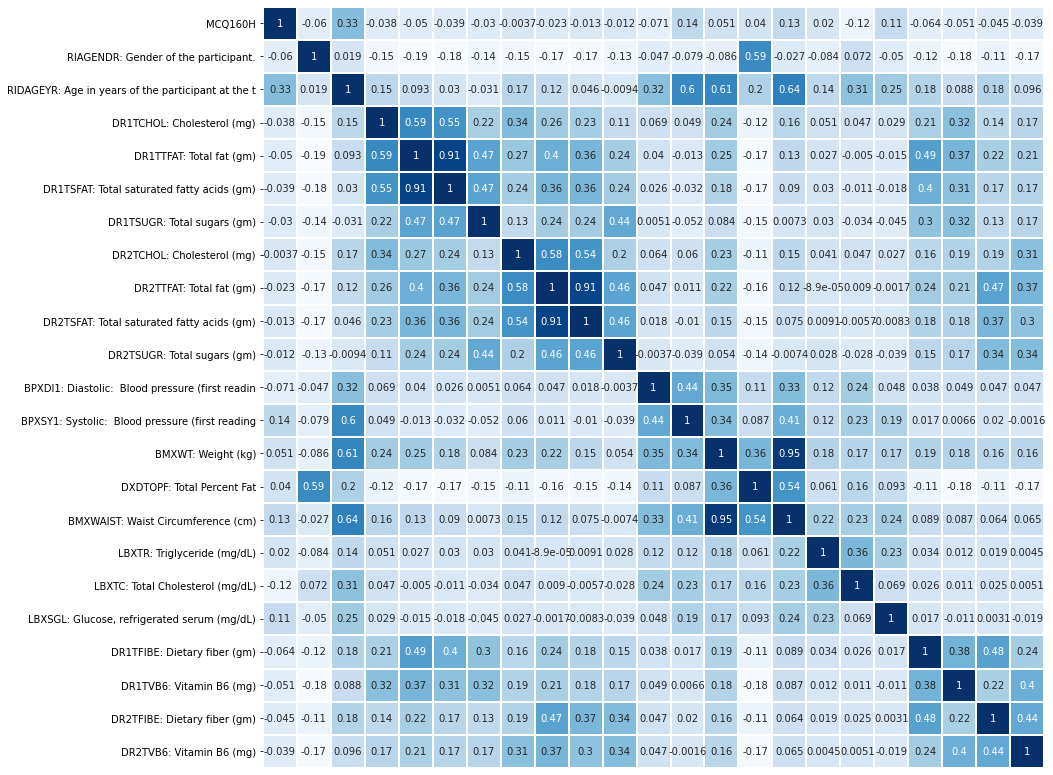

In [9]:
# Let's check the correlations

# 1) We pull the variables names from our vardata object
features_names = vardata.vars_descr_detector(list(dataset.df.columns), 40, True)

# 2) We create the plotter object
plotter = vi.eda_plotter
# 3) Now we use the correlation_matrix method
fig = plotter.correlation_matrix(dataset.df, features_names, figsize = (14, 14))

# To save all the plots as images later
health_reports_path = fo.path_to_folder(2, "reports" + sep + "health")
# Saving plot
#plt.savefig(health_reports_path + "Correlation_matrix.pdf", format = "pdf")

Well, it looks like our chosen independent variables are not quite linearly related with having any cardiovascular disease.
Let's continue the analysis though: Outliers

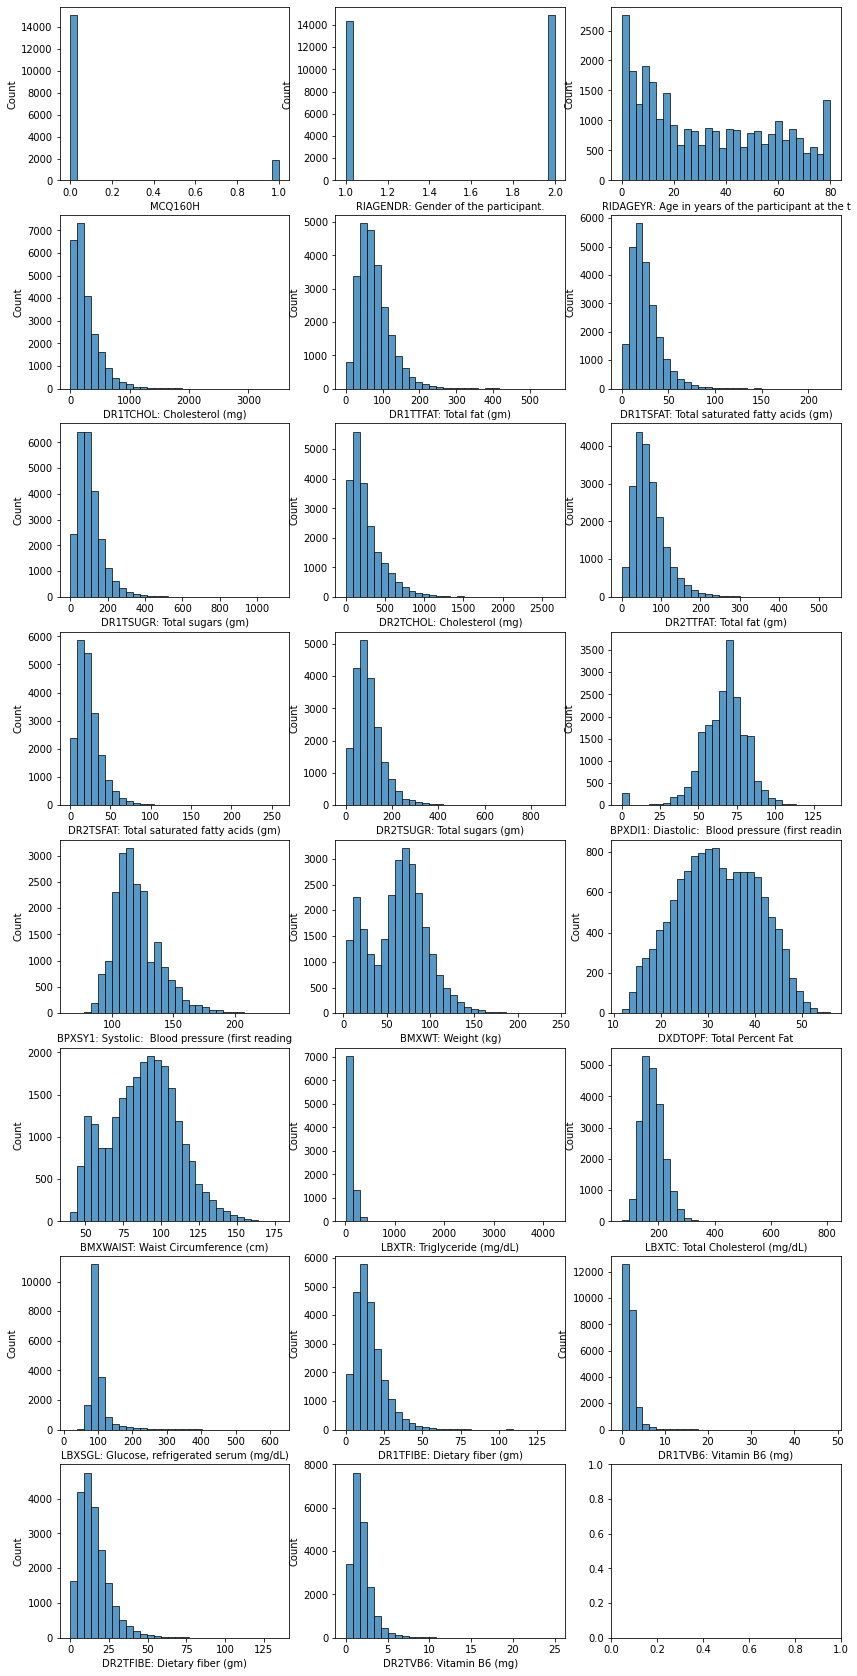

In [10]:
# For this, we will continue to use the plotter object we created
# In this case, we want to see the distribution of the variables
fig2 = plotter.multi_axes_plotter(dataset.df, features_names, 3, "stripplot", (14, 30))
#plt.savefig(health_reports_path + "Distribution_plots.pdf", format = "pdf")

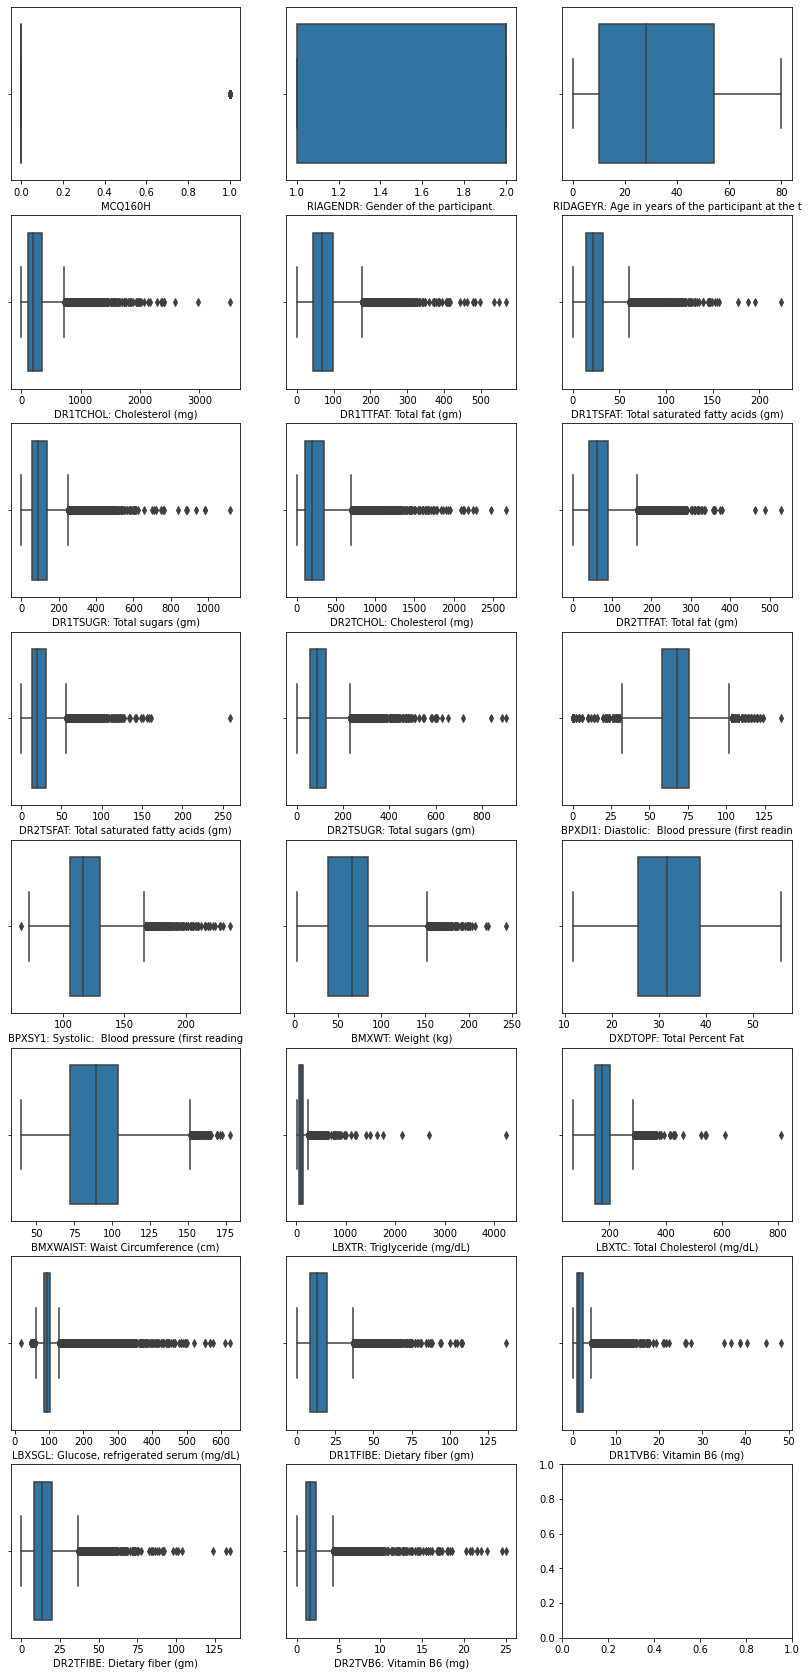

In [11]:
# Let's plot all the variables again, but now using the boxplot graph
# This will give us some extra insights on the data
fig3 = plotter.multi_axes_plotter(dataset.df, features_names, 3, "box", (14, 30))
#plt.savefig(health_reports_path + "Box_plots.pdf", format = "pdf")

Well, we have quite a few outliers

To keep in mind: since some of the independent variables are highly correlated, it's likely for them to have the same observations as outliers. For instance, DR1TTFAT and DR1STFAT are likely to have same participants as outliers

So, by removing the outliers from one of the correlated columns, we are cleaning the other one at the same time


In [12]:
# Let's do an example
DR1TTFAT_outliers = dataset.df[dataset.df.DR1TTFAT > 200]
BPXDI1_outliers = dataset.df[(dataset.df.BPXDI1 < 26) | (dataset.df.BPXDI1 > 105)]
LBXSGL_outliers = dataset.df[dataset.df.LBXSGL > 150]

outliers = [DR1TTFAT_outliers, BPXDI1_outliers, LBXSGL_outliers]

for df_ in outliers:
    print("full dataframe shape:", dataset.df.shape)
    print("filtered dataframe shape:", df_.shape)
    print("\nFull dataframe target values:")
    print(dataset.df.iloc[:, 0].value_counts())
    print("\nFiltered dataframe target values:")
    print(df_.iloc[:, 0].value_counts())
    print("\nNaNs:")
    print(df_.isna().sum())
    print("-" * 50)

full dataframe shape: (29213, 23)
filtered dataframe shape: (458, 23)

Full dataframe target values:
0.0    15043
1.0     1842
Name: MCQ160H, dtype: int64

Filtered dataframe target values:
0.0    330
1.0     26
Name: MCQ160H, dtype: int64

NaNs:
MCQ160H     102
RIAGENDR      0
RIDAGEYR      0
DR1TCHOL      0
DR1TTFAT      0
DR1TSFAT      0
DR1TSUGR      0
DR2TCHOL     66
DR2TTFAT     66
DR2TSFAT     66
DR2TSUGR     66
BPXDI1       38
BPXSY1       38
BMXWT         4
DXDTOPF     149
BMXWAIST     10
LBXTR       269
LBXTC        27
LBXSGL       44
DR1TFIBE      0
DR1TVB6       0
DR2TFIBE     66
DR2TVB6      66
dtype: int64
--------------------------------------------------
full dataframe shape: (29213, 23)
filtered dataframe shape: (391, 23)

Full dataframe target values:
0.0    15043
1.0     1842
Name: MCQ160H, dtype: int64

Filtered dataframe target values:
0.0    137
1.0     31
Name: MCQ160H, dtype: int64

NaNs:
MCQ160H     223
RIAGENDR      0
RIDAGEYR      0
DR1TCHOL     61
DR1TTFAT  

As we can see, there are some positive values within the outliers. This means, by removing the outliers we would also be removing some positive cases and we already have very few. Hence, it seems more interesting to keep the outliers this time.

Next step: let's finish cleaning up the dataframe to feed it into the model.

In [13]:
# We'll first drop the columns "LBXTR" and "DXDTOPF" as they have too many missing values, and when dropping the NaNs, we would end up with many less observations if we keep this variables
to_drop = ["LBXTR", "DXDTOPF"]
dataset.drop_columns(to_drop)

# Drop NaNs (rows)
dataset.drop_nans()

# Let's see what the data looks like now
dataset.df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10969 entries, 83732 to 102956
Data columns (total 21 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   MCQ160H   10969 non-null  float64
 1   RIAGENDR  10969 non-null  int64  
 2   RIDAGEYR  10969 non-null  int64  
 3   DR1TCHOL  10969 non-null  float64
 4   DR1TTFAT  10969 non-null  float64
 5   DR1TSFAT  10969 non-null  float64
 6   DR1TSUGR  10969 non-null  float64
 7   DR2TCHOL  10969 non-null  float64
 8   DR2TTFAT  10969 non-null  float64
 9   DR2TSFAT  10969 non-null  float64
 10  DR2TSUGR  10969 non-null  float64
 11  BPXDI1    10969 non-null  float64
 12  BPXSY1    10969 non-null  float64
 13  BMXWT     10969 non-null  float64
 14  BMXWAIST  10969 non-null  float64
 15  LBXTC     10969 non-null  float64
 16  LBXSGL    10969 non-null  float64
 17  DR1TFIBE  10969 non-null  float64
 18  DR1TVB6   10969 non-null  float64
 19  DR2TFIBE  10969 non-null  float64
 20  DR2TVB6   10969 non-nul

Here we have several variables that refer to the exact same thing. For instance:
- DR1TCHOL --> Total Cholesterol the first interview day
- DR2TCHOL --> Total Cholesterol the second interview day

As we want the users to be able to enter their data, it's going to be easier to ask them for just one measure per risk factor. Thus, we'll combine the similar rows by calculating the mean

In [14]:
# [[pairs we want to combine], new column name]
comb1 = [["DR1TCHOL", "DR2TCHOL"], "MEANCHOL"]      # Total Cholesterol (mg)
comb2 = [["DR1TTFAT", "DR2TTFAT"], "MEANTFAT"]      # Total Fat (g)
comb3 = [["DR1TSFAT", "DR2TSFAT"], "MEANSFAT"]      # Total Saturated Fatty Acid (g)
comb4 = [["DR1TSUGR", "DR2TSUGR"], "MEANSUGR"]      # Total Sugar (g)
comb5 = [["DR1TFIBE", "DR2TFIBE"], "MEANFIBE"]      # Total Fiber (g)
comb6 = [["DR1TVB6", "DR2TVB6"], "MEANTVB6"]        # Total Vitamin B6 (mg)

# list of all combinations
combs = [comb1, comb2, comb3, comb4, comb5, comb6]

# Combine the columns in the first list and use as new name the 2 element (the string)
dataset.pairs_mean(combs, drop_old = True)
dataset.df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10969 entries, 83732 to 102956
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   MCQ160H   10969 non-null  float64
 1   RIAGENDR  10969 non-null  int64  
 2   RIDAGEYR  10969 non-null  int64  
 3   BPXDI1    10969 non-null  float64
 4   BPXSY1    10969 non-null  float64
 5   BMXWT     10969 non-null  float64
 6   BMXWAIST  10969 non-null  float64
 7   LBXTC     10969 non-null  float64
 8   LBXSGL    10969 non-null  float64
 9   MEANCHOL  10969 non-null  float64
 10  MEANTFAT  10969 non-null  float64
 11  MEANSFAT  10969 non-null  float64
 12  MEANSUGR  10969 non-null  float64
 13  MEANFIBE  10969 non-null  float64
 14  MEANTVB6  10969 non-null  float64
dtypes: float64(13), int64(2)
memory usage: 1.3 MB


In [15]:
# Let's have some final check on the values
dataset.df.describe()

,MCQ160H,RIAGENDR,RIDAGEYR,BPXDI1,BPXSY1,BMXWT,BMXWAIST,LBXTC,LBXSGL,MEANCHOL,MEANTFAT,MEANSFAT,MEANSUGR,MEANFIBE,MEANTVB6
count,10969.000000,10969.000000,10969.000000,10969.000000,10969.000000,10969.000000,10969.000000,10969.000000,10969.000000,10969.000000,10969.000000,10969.000000,10969.000000,10969.000000,10969.000000
mean,0.102926,1.521105,49.717112,70.528034,124.609901,82.525052,100.454800,189.749749,103.479989,299.643222,79.516816,25.568269,102.894762,17.068922,2.077235
std,0.303877,0.499577,17.305776,12.886241,18.275876,21.617138,16.632645,41.924842,39.538242,198.111439,38.781540,13.872619,61.885249,9.397976,1.420855
min,0.000000,1.000000,20.000000,0.000000,66.000000,32.300000,55.500000,69.000000,19.000000,0.000000,4.830000,1.129500,0.305000,0.150000,0.034500
25%,0.000000,1.000000,35.000000,64.000000,112.000000,67.300000,88.700000,161.000000,86.000000,160.500000,52.705000,15.854000,60.125000,10.550000,1.289000
50%,0.000000,2.000000,50.000000,72.000000,122.000000,79.300000,99.000000,186.000000,94.000000,255.500000,73.335000,23.086000,90.810000,15.300000,1.799000
75%,0.000000,2.000000,63.000000,78.000000,134.000000,94.100000,110.300000,214.000000,104.000000,387.000000,99.360000,32.305500,130.145000,21.600000,2.471000
max,1.000000,2.000000,80.000000,124.000000,230.000000,198.900000,172.500000,813.000000,626.000000,2443.000000,429.050000,190.057000,892.645000,105.850000,32.430000


In [16]:
# One final thing to do before feeding the data into the models is transforming the gender variable (RIAGENDR) into a dummy one:
dataset.df.RIAGENDR.value_counts()

2    5716
1    5253
Name: RIAGENDR, dtype: int64

In [17]:
# We will do this making use of one of the object's method
mapper = {1 : "Male", 2 : "Female"}
dataset.dummies_transform("RIAGENDR", mapper)
dataset.df.describe()

,MCQ160H,RIDAGEYR,BPXDI1,BPXSY1,BMXWT,BMXWAIST,LBXTC,LBXSGL,MEANCHOL,MEANTFAT,MEANSFAT,MEANSUGR,MEANFIBE,MEANTVB6,Female,Male
count,10969.000000,10969.000000,10969.000000,10969.000000,10969.000000,10969.000000,10969.000000,10969.000000,10969.000000,10969.000000,10969.000000,10969.000000,10969.000000,10969.000000,10969.000000,10969.000000
mean,0.102926,49.717112,70.528034,124.609901,82.525052,100.454800,189.749749,103.479989,299.643222,79.516816,25.568269,102.894762,17.068922,2.077235,0.521105,0.478895
std,0.303877,17.305776,12.886241,18.275876,21.617138,16.632645,41.924842,39.538242,198.111439,38.781540,13.872619,61.885249,9.397976,1.420855,0.499577,0.499577
min,0.000000,20.000000,0.000000,66.000000,32.300000,55.500000,69.000000,19.000000,0.000000,4.830000,1.129500,0.305000,0.150000,0.034500,0.000000,0.000000
25%,0.000000,35.000000,64.000000,112.000000,67.300000,88.700000,161.000000,86.000000,160.500000,52.705000,15.854000,60.125000,10.550000,1.289000,0.000000,0.000000
50%,0.000000,50.000000,72.000000,122.000000,79.300000,99.000000,186.000000,94.000000,255.500000,73.335000,23.086000,90.810000,15.300000,1.799000,1.000000,0.000000
75%,0.000000,63.000000,78.000000,134.000000,94.100000,110.300000,214.000000,104.000000,387.000000,99.360000,32.305500,130.145000,21.600000,2.471000,1.000000,1.000000
max,1.000000,80.000000,124.000000,230.000000,198.900000,172.500000,813.000000,626.000000,2443.000000,429.050000,190.057000,892.645000,105.850000,32.430000,1.000000,1.000000


In [18]:
dataset.df.MCQ160H.value_counts()

0.0    9840
1.0    1129
Name: MCQ160H, dtype: int64

In [19]:
data_path

'/Users/jonathansuarezcaceres/Downloads/1_DataScience/Projects/0_Nutrition/data/health/'

In [20]:
### DON'T EXECUTE THIS ONE

# We will take this dataset as it is and save it as our cleaned data, because it's the one we'll be using for ML and neural networks
#path_to_save = data_path + "7_cleaned_data" + sep + "cleaned_data.csv"
#dataset.df.to_csv(path_to_save)

# ML Models and Predictions

### Ensembler

As there are many possibilities when it comes to classification models, we will test them all and have a look at the main metrics to see which one performs better. From there, we will decide which one we want to keep for further tuning.

In [21]:
### Prepare data for the ML models
# We won't scale or balance the data for this first round
dataset.model_data(split = .2, cv = 3, epochs = 1)

### Choose models for test against each other
# Same seed of all of them
seed = 42

# Logistic Regression
log1 = LogisticRegression(n_jobs = -1, random_state = seed)
log2 = LogisticRegression(n_jobs = -1, max_iter = 300, random_state = seed)

# Random Forest
rf1 = RandomForestClassifier(n_jobs = -1, random_state = seed)
rf2 = RandomForestClassifier(n_jobs = -1, random_state = seed, max_depth = 10)
rf3 = RandomForestClassifier(n_jobs = -1, random_state = seed, max_depth = 20) 
rf4 = RandomForestClassifier(n_jobs = -1, random_state = seed, max_features = "sqrt") 
rf5 = RandomForestClassifier(n_jobs = -1, random_state = seed, max_features = "log2") 

# KNeighbors
knn1 = KNeighborsClassifier(n_jobs = -1)
knn2 = KNeighborsClassifier(n_jobs = -1, weights = "distance")

models = [log1, log2, rf1, rf2, rf3, rf4, rf5, knn1, knn2]

In [22]:
### Models comparison
# Ensemble models
ensembler = mo.model_ensembler(models)
# Load data
ensembler.load_data(dataset.X_train, dataset.X_test, dataset.y_train, dataset.y_test, features_names, dataset.kfold)
# Train them
ensembler.models_tester()
# Let's see the performance
ensembler.metrics

,Test_score,Train_score,Test_score_drop,Accuracy,Precision,Recall,F1_score,Confusion_matrix
"LogisticRegression(max_iter=300, n_jobs=-1, random_state=42)",0.902461,0.899487,0.003306,0.902461,0.47619,0.09434,0.15748,"[[1960, 22], [192, 20]]"
"RandomForestClassifier(max_depth=20, n_jobs=-1, random_state=42)",0.90155,0.965698,-0.066427,0.90155,0.388889,0.033019,0.06087,"[[1971, 11], [205, 7]]"
"RandomForestClassifier(max_depth=10, n_jobs=-1, random_state=42)",0.901094,0.925698,-0.026579,0.901094,0.222222,0.009434,0.0181,"[[1975, 7], [210, 2]]"
"LogisticRegression(n_jobs=-1, random_state=42)",0.900638,0.897778,0.003186,0.900638,0.421053,0.075472,0.128,"[[1960, 22], [196, 16]]"
"RandomForestClassifier(n_jobs=-1, random_state=42)",0.900182,0.965698,-0.067843,0.900182,0.230769,0.014151,0.026667,"[[1972, 10], [209, 3]]"
"RandomForestClassifier(max_features='sqrt', n_jobs=-1, random_state=42)",0.900182,0.965698,-0.067843,0.900182,0.230769,0.014151,0.026667,"[[1972, 10], [209, 3]]"
"RandomForestClassifier(max_features='log2', n_jobs=-1, random_state=42)",0.900182,0.965698,-0.067843,0.900182,0.230769,0.014151,0.026667,"[[1972, 10], [209, 3]]"
"KNeighborsClassifier(n_jobs=-1, weights='distance')",0.892434,0.963419,-0.07368,0.892434,0.26,0.061321,0.099237,"[[1945, 37], [199, 13]]"
KNeighborsClassifier(n_jobs=-1),0.891978,0.90188,-0.01098,0.891978,0.244898,0.056604,0.091954,"[[1945, 37], [200, 12]]"


Models are sorted by "Test_score" on descending value.

We can see that LogisticRegression is the model that's actually performaing the best, improving its performance when working with the test data

In [23]:
### DON'T EXECUTE THIS ONE

models_path = fo.path_to_folder(2, "models")
# We will save this first models comparison
#ensembler.metrics.to_csv(models_path + "model_comparison_noscale_nobalance.csv")

# Now we will save all the models (in the same folder)
#ensembler.models_saver(models_path + "model_comparison_noscale_nobalance")

In [24]:
# Now, let's try the same but scaling and balancing the data

# Data
dataset.model_data(split = .2, cv = 3, epochs = 1, scaler = True, balance = .8)

# We will use the same models, so no need to redefine them
### Models comparison
# Ensemble models
ensembler2 = mo.model_ensembler(models)
# Load data
ensembler2.load_data(dataset.X_train, dataset.X_test, dataset.y_train, dataset.y_test, features_names, dataset.kfold)
# Train them
ensembler2.models_tester()
# Let's see the performance
ensembler2.metrics

,Test_score,Train_score,Test_score_drop,Accuracy,Precision,Recall,F1_score,Confusion_matrix
"RandomForestClassifier(n_jobs=-1, random_state=42)",0.842297,0.971083,-0.132621,0.842297,0.267361,0.363208,0.308,"[[1771, 211], [135, 77]]"
"RandomForestClassifier(max_features='sqrt', n_jobs=-1, random_state=42)",0.842297,0.971083,-0.132621,0.842297,0.267361,0.363208,0.308,"[[1771, 211], [135, 77]]"
"RandomForestClassifier(max_features='log2', n_jobs=-1, random_state=42)",0.842297,0.971083,-0.132621,0.842297,0.267361,0.363208,0.308,"[[1771, 211], [135, 77]]"
"RandomForestClassifier(max_depth=20, n_jobs=-1, random_state=42)",0.837284,0.969528,-0.136401,0.837284,0.260726,0.372642,0.306796,"[[1758, 224], [133, 79]]"
"RandomForestClassifier(max_depth=10, n_jobs=-1, random_state=42)",0.801732,0.901442,-0.110612,0.801732,0.242494,0.495283,0.325581,"[[1654, 328], [107, 105]]"
"LogisticRegression(n_jobs=-1, random_state=42)",0.765725,0.767817,-0.002725,0.765725,0.233216,0.622642,0.339332,"[[1548, 434], [80, 132]]"
"LogisticRegression(max_iter=300, n_jobs=-1, random_state=42)",0.765725,0.767817,-0.002725,0.765725,0.233216,0.622642,0.339332,"[[1548, 434], [80, 132]]"
KNeighborsClassifier(n_jobs=-1),0.712853,0.881858,-0.191646,0.712853,0.169304,0.504717,0.253555,"[[1457, 525], [105, 107]]"
"KNeighborsClassifier(n_jobs=-1, weights='distance')",0.712853,0.95164,-0.250922,0.712853,0.169304,0.504717,0.253555,"[[1457, 525], [105, 107]]"


In [25]:
### DON'T EXECUTE THIS ONE

# We will save this first models comparison
#ensembler2.metrics.to_csv(models_path + "model_comparison_scaled_balanced.csv")

# Now we will save all the models (in the same folder)
#ensembler2.models_saver(models_path + "model_comparison_scaled_balanced")

Well, it seems like all the models are performing worse in terms of test score. However, we can see how all of them have a better recall, meaning that they are better at the detecting the positives, which is our main goal.

Besides, the drop in precision is lower than the increase in recall. This means, even though we are making some more errors by detecting false positives, it's still worth.

Surprise (irony): RandomForest is now the one performing better, although we can see that all RandomForest models are overfitting.

We will stick to LogisticRegression model for further tests.

Now that we have chosen LogisticRegression, let's get deeper into the model details

In [26]:
# Let's prepare the data and choose a model

# 1) Prepare data for ml models
dataset.model_data(split = .2, cv = 10, epochs = 2, balance = 1)

# 2) Choose model
model = LogisticRegression(n_jobs = -1, max_iter = 500, warm_start = True)

# 3) We create a ml_model object and load the data
my_model = mo.ml_model(model)

# Load data
my_model.load_data(dataset.X_train, dataset.X_test, dataset.y_train, dataset.y_test, features_names, dataset.kfold)

# 4) We train the model
# verb = True returns some info about the training
my_model.ml_trainer(verb = True)


-- Model 1 --
-------------------------
>train score: 0.7647765837104072
>test score: 0.7652671755725191
-------------------------
Set structure:
Train structure: {0.0: 0.5, 1.0: 0.5}
Validation structure: {0.0: 0.5, 1.0: 0.5}
###########################################################################

-- Model 2 --
-------------------------
>train score: 0.767816742081448
>test score: 0.7868956743002544
-------------------------
Set structure:
Train structure: {0.0: 0.5, 1.0: 0.5}
Validation structure: {0.0: 0.5, 1.0: 0.5}
###########################################################################

-- Model 3 --
-------------------------
>train score: 0.7707861990950227
>test score: 0.7970737913486005
-------------------------
Set structure:
Train structure: {0.0: 0.5, 1.0: 0.5}
Validation structure: {0.0: 0.5, 1.0: 0.5}
###########################################################################

-- Model 4 --
-------------------------
>train score: 0.7722709276018099
>test score: 0.

We can see that balancing the data forced the train and validation sets to be aprox 50/50. This will come in handy later, when we try to predict the positives, as we are now helping the model overcome the bias in the data.

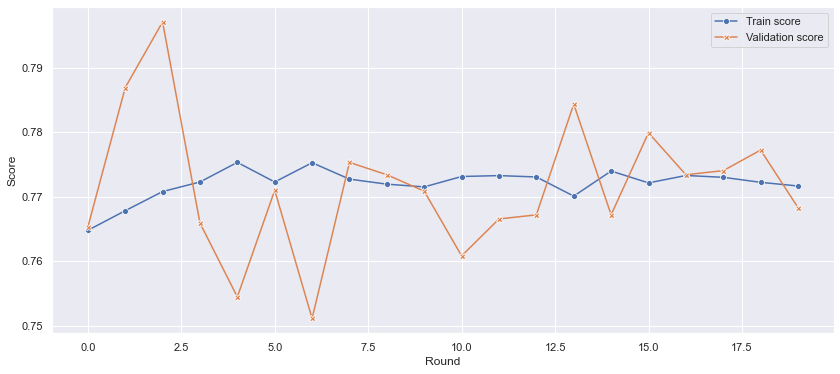

In [27]:
# We create the plotter object
ml_plotter = vi.ml_model_plotter()

# We use the plotter method "train_val_plot" to see the scores evolution
fig4 = ml_plotter.train_val_plot(my_model)
# To save the figure
#plt.savefig(health_reports_path + "Cross_validation.pdf", format = "pdf")

In [28]:
my_model.ml_tester(verb = True)

Train structure: {0.0: 50.0, 1.0: 50.0}
Test structure: {0.0: 90.33728350045578, 1.0: 9.662716499544212}
###########################################################################
>Train score: 0.7713158564520234
>Test score: 0.7333637192342753
###########################################################################
Confusion matrix
[[1459  523]
 [  62  150]]
###########################################################################
Precision metrics
Accuracy: 0.7333637192342753
Precision: 0.22288261515601784
Recall: 0.7075471698113207
F1 score: 0.33898305084745767


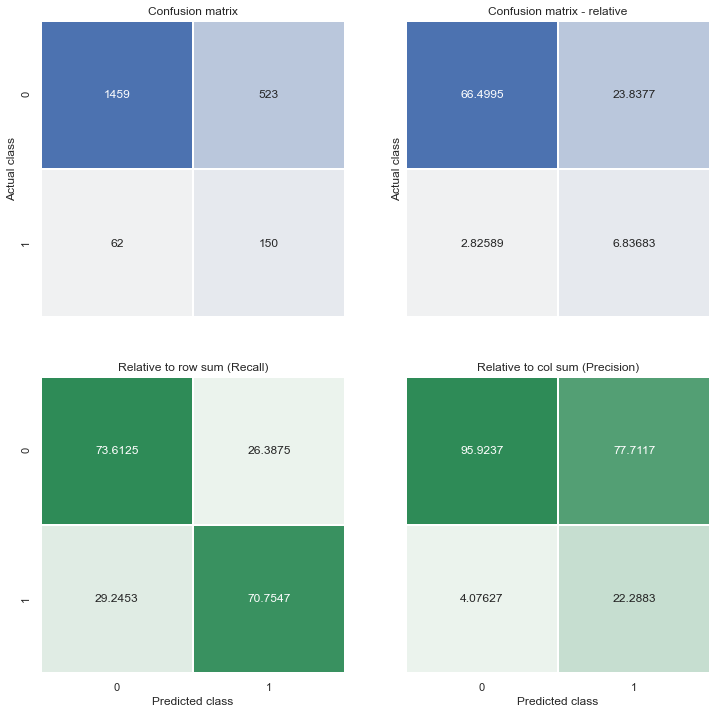

In [29]:
# We use the plotter method "test_metrics" to see how well our model is actually doing in its predictions
fig5 = ml_plotter.test_metrics(my_model)
# To save the figure
#plt.savefig(health_reports_path + "Confusion_matrix.pdf", format = "pdf")

With 73.5% score, our model is predicting fairly well, and what's more important: it is getting right most of the positive cases. However, this comes at a cost: it is falsely predicting quite a few positives (523 in test sample).

To conclude this section, let's save this model and try with Neural Networks to see if they can improve the current results.

In [30]:
X, y = dataset.full_model_data(False, 1)
my_model.ready_to_use(X, y, verb = True)

Model results - Full data
>Score: 0.7696646341463415
###########################################################################
Confusion matrix
[[7262 2578]
 [1955 7885]]
###########################################################################
Precision metrics
Accuracy: 0.7696646341463415
Precision: 0.753607951830259
Recall: 0.8013211382113821
F1 score: 0.7767325025858246


In [31]:
# Last check to see the actual results
to_pred = dataset.df[dataset.df["MCQ160H"] == 1]
X_pred, y_pred = to_pred.loc[:, "RIDAGEYR":], to_pred.loc[:, "MCQ160H"]
X_pred = np.array(X_pred)

#X_pred = StandardScaler().fit_transform(X_pred)

predictions = my_model.ml_predictions(X_pred)
comparison = pd.DataFrame([y_pred.values, predictions], index = ["real", "prediction"]).T
comparison["diff"] = comparison.real - comparison.prediction
comparison.sum()

real          1129.0
prediction     861.0
diff           268.0
dtype: float64

In [32]:
### DON'T EXECUTE THIS ONE

# Now we will save this model as the best one so far
#my_model.model_saver(models_path + "BM_LogisticRegression")

# Neural network

In [33]:
# Let's start by defining the neural network structure
# This is to reset the neural network everytime we edit anything
tf.keras.backend.clear_session()

nn = keras.Sequential([
    layers.InputLayer(input_shape = (15,)),
    layers.Dense(32, activation = "relu"),
    layers.Dense(16, activation = "relu"),
    layers.Dense(1, activation = "sigmoid", name = "predictions")
])

nn.compile(
    optimizer = keras.optimizers.Adam(lr = .005),
    loss = "binary_crossentropy",
    metrics = [keras.metrics.BinaryAccuracy(name = "binary_accuracy",
                                            threshold = .5)]
)

nn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                512       
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
predictions (Dense)          (None, 1)                 17        
Total params: 1,057
Trainable params: 1,057
Non-trainable params: 0
_________________________________________________________________


In [34]:
history = nn.fit(dataset.X_train, dataset.y_train, epochs = 20, verbose = 1)

Epoch 1/20
492/492 [==============================] - 1s 832us/step - loss: 1.1639 - binary_accuracy: 0.6662
Epoch 2/20
492/492 [==============================] - 1s 1ms/step - loss: 0.5781 - binary_accuracy: 0.7239
Epoch 3/20
492/492 [==============================] - 1s 1ms/step - loss: 0.5416 - binary_accuracy: 0.7389
Epoch 4/20
492/492 [==============================] - 1s 1ms/step - loss: 0.5278 - binary_accuracy: 0.7471
Epoch 5/20
492/492 [==============================] - 0s 1ms/step - loss: 0.5277 - binary_accuracy: 0.7471
Epoch 6/20
492/492 [==============================] - 1s 1ms/step - loss: 0.5185 - binary_accuracy: 0.7502
Epoch 7/20
492/492 [==============================] - 1s 1ms/step - loss: 0.5155 - binary_accuracy: 0.7536
Epoch 8/20
492/492 [==============================] - 1s 1ms/step - loss: 0.5107 - binary_accuracy: 0.7534
Epoch 9/20
492/492 [==============================] - 1s 1ms/step - loss: 0.5021 - binary_accuracy: 0.7585
Epoch 10/20
492/492 [==============

In [35]:
nn.evaluate(dataset.X_test, dataset.y_test)

69/69 [==============================] - 0s 862us/step - loss: 0.4558 - binary_accuracy: 0.7429


[0.4558168947696686, 0.742935299873352]

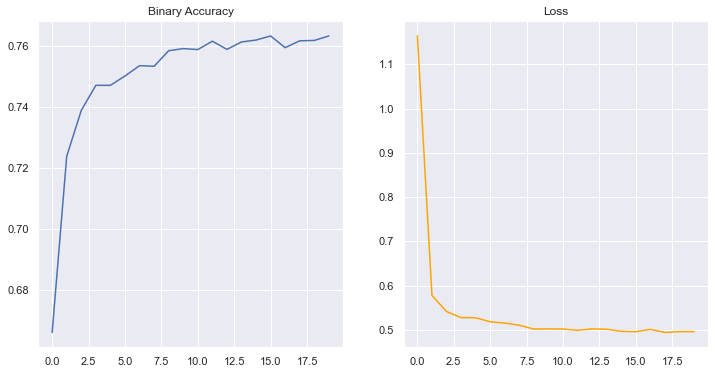

In [38]:
# Let's have a more visual look at the results

# Object to plot NN results
nn_plotter = vi.nn_plotter()

# 1) Visualize accuracy and loss progression
fig6 = nn_plotter.model_progression(history)
plt.savefig(health_reports_path + "NN_progression.pdf", format = "pdf")

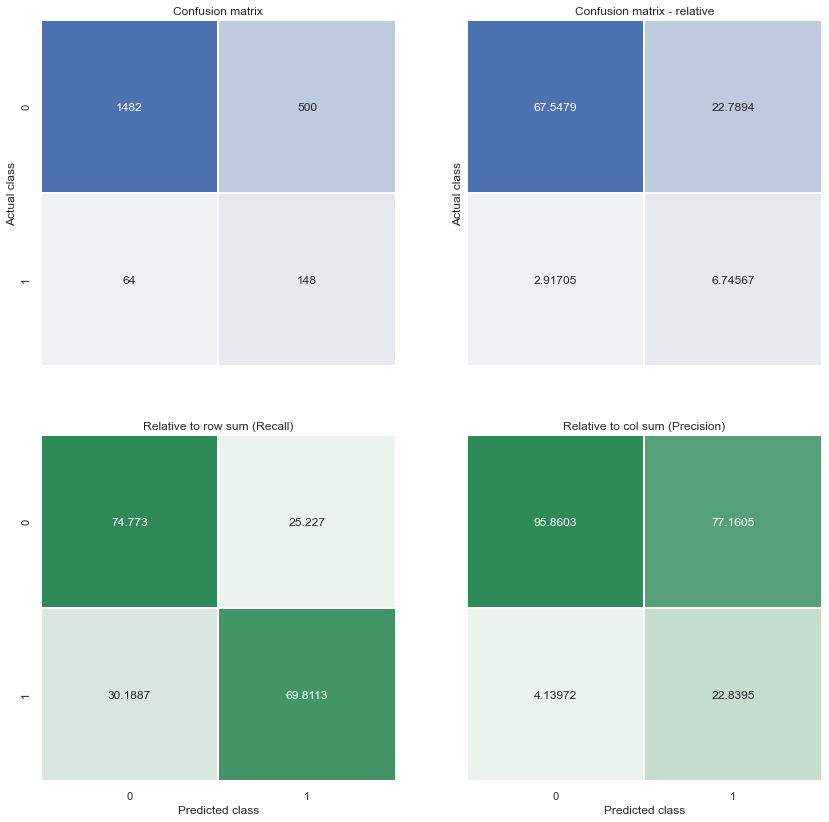

In [39]:
# 2) Let's see the confusion matrix
fig7 = nn_plotter.test_results(nn, dataset)
plt.savefig(health_reports_path + "NN_confusion_matrix.pdf", format = "pdf")

Well, as we can see, Neural Network didn't improve the results we obtained with the LogisticRegression. However, results were pretty close.

Let's save this model too.

In [40]:
nn.save(models_path + "NN.h5")